In [ ]:
! unzip '/content/drive/MyDrive/CBIR/DATA/CorelDB.zip' -d './Data'

In [1]:
! pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 30.8 MB/s 


In [2]:
# import libraries
import os
import cv2
import timm
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler 
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [8]:
"""
CREATE DATA FILE CSV
"""
DATA_FOLDER = '/content/Data/CorelDB/'

anchors = []
negatives = []
positives = []

for sub_folder in tqdm(os.listdir(DATA_FOLDER)):
    n_sub_folder = len(os.listdir(DATA_FOLDER))
    sub_folder_path = DATA_FOLDER + sub_folder + '/'
    for file_name in os.listdir(sub_folder_path):
        if file_name.endswith('.jpg'):
          n_positive = len(os.listdir(sub_folder_path))
          anchor_file_name = file_name
          anchor_file_path = sub_folder_path + file_name
          for i in range(2):
              # random positive
              index_positive = random.randint(0, n_positive-1)
              positive_file_name = os.listdir(sub_folder_path)[index_positive]
              while anchor_file_name == positive_file_name or not positive_file_name.endswith('.jpg'):
                  index_positive = random.randint(0, n_positive-1)
                  positive_file_name = os.listdir(sub_folder_path)[index_positive]
              positive_file_path = sub_folder_path + positive_file_name

              # random negative
              index_sub_folder = random.randint(0, n_sub_folder-1)
              negative_sub_folder = os.listdir(DATA_FOLDER)[index_sub_folder]
              while sub_folder == negative_sub_folder:
                  index_sub_folder = random.randint(0, n_sub_folder-1)
                  negative_sub_folder = os.listdir(DATA_FOLDER)[index_sub_folder]
              negative_sub_folder_path = DATA_FOLDER + negative_sub_folder + '/'
              n_negative = len(os.listdir(negative_sub_folder_path))
              index_negative = random.randint(0, n_negative-1)
              negative_file_name = os.listdir(negative_sub_folder_path)[index_negative]
              while not negative_file_name.endswith('.jpg'):
                  index_negative = random.randint(0, n_negative-1)
                  negative_file_name = os.listdir(negative_sub_folder_path)[index_negative]
              negative_file_path = negative_sub_folder_path + negative_file_name

              anchors.append(anchor_file_path)
              negatives.append(negative_file_path)
              positives.append(positive_file_path)

data = {
    'Anchor': anchors,
    'Negative': negatives,
    'Positive': positives
}

df = pd.DataFrame(data=data)
df.to_csv('./data.csv', index=None)

100%|██████████| 80/80 [00:06<00:00, 11.53it/s]


In [9]:
df = pd.read_csv('./data.csv')
print(df.shape)

(21600, 3)


In [10]:
df.head()

,Anchor,Negative,Positive
0,/content/Data/CorelDB/wl_deer/104089.jpg,/content/Data/CorelDB/wl_goat/168068.jpg,/content/Data/CorelDB/wl_deer/104044.jpg
1,/content/Data/CorelDB/wl_deer/104089.jpg,/content/Data/CorelDB/sc_cloud/191059.jpg,/content/Data/CorelDB/wl_deer/77065.jpg
2,/content/Data/CorelDB/wl_deer/77037.jpg,/content/Data/CorelDB/obj_bonsai/353093.jpg,/content/Data/CorelDB/wl_deer/77041.jpg
3,/content/Data/CorelDB/wl_deer/77037.jpg,/content/Data/CorelDB/obj_mineral/409009.jpg,/content/Data/CorelDB/wl_deer/104033.jpg
4,/content/Data/CorelDB/wl_deer/77074.jpg,/content/Data/CorelDB/wl_porp/314031.jpg,/content/Data/CorelDB/wl_deer/77057.jpg


In [11]:
row = df.iloc[15000]

A_img = cv2.imread(row.Anchor)
P_img = cv2.imread(row.Positive)
N_img = cv2.imread(row.Negative)

A_img = cv2.cvtColor(A_img, cv2.COLOR_BGR2RGB)
P_img = cv2.cvtColor(P_img, cv2.COLOR_BGR2RGB)
N_img = cv2.cvtColor(N_img, cv2.COLOR_BGR2RGB)

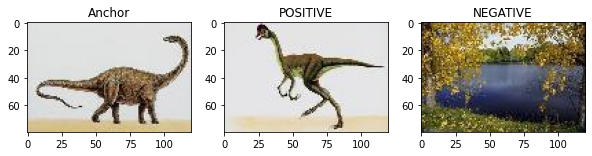

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))

ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('POSITIVE')
ax2.imshow(P_img)

ax3.set_title('NEGATIVE')
ax3.imshow(N_img)

In [63]:
# train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
# print("Shape of train set: ", train_set.shape)
# print("Shape of test set: ", test_set.shape)

Shape of train set:  (17280, 3)
Shape of test set:  (4320, 3)


In [66]:
# train_set.head()

,Anchor,Negative,Positive
17604,/content/Data/CorelDB/pl_mashroom/208046.jpg,/content/Data/CorelDB/woman/388010.jpg,/content/Data/CorelDB/pl_mashroom/208070.jpg
16962,/content/Data/CorelDB/obj_car/29079.jpg,/content/Data/CorelDB/sc_waterfal/377023.jpg,/content/Data/CorelDB/obj_car/521069.jpg
17226,/content/Data/CorelDB/texture_5/343098.jpg,/content/Data/CorelDB/obj_moleculr/533090.jpg,/content/Data/CorelDB/texture_5/343056.jpg
17878,/content/Data/CorelDB/obj_decoys/655015.jpg,/content/Data/CorelDB/pet_dog/247047.jpg,/content/Data/CorelDB/obj_decoys/655037.jpg
7228,/content/Data/CorelDB/fitness/282086.jpg,/content/Data/CorelDB/sc_sunset/345039.jpg,/content/Data/CorelDB/fitness/282010.jpg


In [13]:
"""
CLASS DATASET
"""
class APNDataset(Dataset):
    def __init__(self, df=None, transform=None, train=True):
        self.df = df
        # if train:
        #   self.df = train_set
        # else:
        #   self.df = test_set
        self.transform = transform

    def __len__(self):
        return len(self.df)
  
    def __getitem__(self, index):
        row = self.df.iloc[index]

        A_img = cv2.imread(row.Anchor)
        P_img = cv2.imread(row.Positive)
        N_img = cv2.imread(row.Negative)

        # A_img = Image.open(row.Anchor)
        # P_img = Image.open(row.Positive)
        # N_img = Image.open(row.Negative)

        A_img = Image.fromarray(A_img)
        P_img = Image.fromarray(P_img)
        N_img = Image.fromarray(N_img)

        A_img = A_img.convert('RGB')
        P_img = P_img.convert('RGB')
        N_img = N_img.convert('RGB')

        if self.transform:
          A_img = self.transform(A_img)
          P_img = self.transform(P_img)
          N_img = self.transform(N_img)
        
        A_img = np.array(A_img)
        P_img = np.array(P_img)
        N_img = np.array(N_img)

        return A_img, P_img, N_img


In [14]:
class APNDataLoader:
    def __init__(self, df,
                       batch_size=8,
                       random_seed=42,
                       valid_size=0.2,
                       shuffle=True,
                       train=True):
        self.df = df
        self.batch_size = batch_size
        self.random_seed = random_seed
        self.valid_size = valid_size
        self.shuffle = shuffle
        self.train = train
        
        
    def load_data(self):
        # Create transform
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]

        train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            # transforms.RandomHorizontalFlip(),
            # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
            # transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, resample=False, fillcolor=0),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        test_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        # eval
        if not self.train:
            test_dataset = APNDataset(df=self.df, transfrom=test_transform, train=False)
            test_loader = DataLoader(
                dataset=test_dataset, batch_size=self.batch_size
            )
            return test_loader

        # train
        # Create dataset
        train_dataset = APNDataset(df=self.df, transform=train_transform, train=True)
        valid_dataset = APNDataset(df=self.df, transform=train_transform, train=True)

        # Train-Valid dataset split
        num_train = train_dataset.__len__()
        indices = list(range(num_train))
        split = int(np.floor(self.valid_size * num_train))

        if self.shuffle:
            np.random.seed(self.random_seed)
            np.random.seed(indices)

        train_idx, valid_idx = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)
        
        # Create data loader
        train_loader = DataLoader(
            dataset=train_dataset, batch_size=self.batch_size, sampler=train_sampler
        )

        valid_loader = DataLoader(
            dataset=valid_dataset, batch_size=self.batch_size, sampler=valid_sampler
        )

        return (train_loader, valid_loader)

In [15]:
class APN_Model(nn.Module):
    def __init__(self, emb_size=512):
        super(APN_Model, self).__init__()

        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
        self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings

In [16]:
def train_fn(model, dataloader, optimizer, criterion):
    model.train() # ON Dropout
    total_loss = 0.0
    for A, P, N in tqdm(dataloader):
        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)

        loss = criterion(A_embs, P_embs, N_embs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

In [17]:
def eval_fn(model, dataloader, criterion):
    model.eval() # OFF Dropout
    total_loss = 0.0
    for A, P, N in tqdm(dataloader):
        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)

        loss = criterion(A_embs, P_embs, N_embs)

        total_loss += loss.item()
    return total_loss / len(dataloader)

In [18]:
# HYPERPARAMETERS
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 30
BATCH_SIZE = 16
LR = 0.005

In [ ]:
# MODEL
model = APN_Model()
model = model.to(DEVICE)
print(model)

In [20]:
# LOSS FUNCTION AND OPTIMIZER
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [21]:
dataloader = APNDataLoader(df=df, batch_size=BATCH_SIZE, train=True)
train_loader, valid_loader = dataloader.load_data()

In [22]:
best_valid_loss = 1e9
print("START TRAINING...")
for i in range(EPOCHS):
    train_loss = train_fn(model, train_loader, optimizer, criterion)
    valid_loss = eval_fn(model, valid_loader, criterion)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), './best.pt')
        best_valid_loss = valid_loss
        print("SAVED_WEIGHTS_SUCCESS!")
    print(f"EPOCHS : {i+1} / {EPOCHS} train_loss : {train_loss} valid_loss : {valid_loss}")

START TRAINING...


100%|██████████| 270/270 [00:45<00:00,  5.89it/s]


SAVED_WEIGHTS_SUCCESS!
EPOCHS : 1 / 30 train_loss : 0.7786740138712857 valid_loss : 0.5745493452858041


100%|██████████| 270/270 [00:45<00:00,  5.92it/s]


SAVED_WEIGHTS_SUCCESS!
EPOCHS : 2 / 30 train_loss : 0.5039754741100801 valid_loss : 0.551404777555554


100%|██████████| 270/270 [00:45<00:00,  5.98it/s]


EPOCHS : 3 / 30 train_loss : 0.43721256505835937 valid_loss : 0.6161202067302333


100%|██████████| 270/270 [00:45<00:00,  5.93it/s]


SAVED_WEIGHTS_SUCCESS!
EPOCHS : 4 / 30 train_loss : 0.41791871629172456 valid_loss : 0.43713631930726543


100%|██████████| 270/270 [00:44<00:00,  6.03it/s]


EPOCHS : 5 / 30 train_loss : 0.39256547557672966 valid_loss : 0.49116921173753564


100%|██████████| 270/270 [00:45<00:00,  5.93it/s]


EPOCHS : 6 / 30 train_loss : 0.3825694781245181 valid_loss : 0.5810666434190891


100%|██████████| 270/270 [00:45<00:00,  5.91it/s]


EPOCHS : 7 / 30 train_loss : 0.3907539656109832 valid_loss : 0.4783742331520275


100%|██████████| 270/270 [00:45<00:00,  5.99it/s]


EPOCHS : 8 / 30 train_loss : 0.3875398132053238 valid_loss : 0.5011869998993697


100%|██████████| 270/270 [00:44<00:00,  6.05it/s]


EPOCHS : 9 / 30 train_loss : 0.34477073419839144 valid_loss : 0.5189646702121805


100%|██████████| 270/270 [00:44<00:00,  6.02it/s]


EPOCHS : 10 / 30 train_loss : 0.29413668599531606 valid_loss : 0.4770550803729781


100%|██████████| 270/270 [00:44<00:00,  6.04it/s]


EPOCHS : 11 / 30 train_loss : 0.2507832125795108 valid_loss : 0.4986353823984111


  9%|▉         | 96/1080 [00:32<05:37,  2.91it/s]


KeyboardInterrupt: ignored

In [29]:
print(DEVICE)

cuda


In [30]:
print(torch.cuda.get_device_name(DEVICE))

Tesla T4


In [19]:
! nvidia-smi

Mon Sep 12 08:07:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W /  70W |   5522MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [82]:
def get_encoding_csv(model, anc_img_names):
    mean = [0.4914, 0.4822, 0.4465]
    std = [0.2023, 0.1994, 0.2010]

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()
    with torch.no_grad():
        for image_path in tqdm(anc_img_names_arr):
            image = cv2.imread(image_path)
            image = Image.fromarray(image)
            image = image.convert('RGB')
            image = test_transform(image)
            image = image.unsqueeze(0)
            image = image.to(DEVICE)
            A_enc = model(image)
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_names = pd.DataFrame(
            { 'Anchor': anc_img_names_arr}
        )
        df_enc = pd.concat([df_names, encodings], axis=1)

    return df_enc

In [ ]:
model = APN_Model()
model.load_state_dict(torch.load('./best.pt'))
model = model.to(DEVICE)
model.eval()

In [83]:
df_enc = get_encoding_csv(model, df["Anchor"].unique())
df_enc.head()

100%|██████████| 10800/10800 [02:16<00:00, 79.03it/s]


,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,/content/Data/CorelDB/wl_deer/104089.jpg,-0.927846,-1.705284,0.540830,0.377263,0.226575,-0.630332,0.058931,0.114023,1.339567,...,0.245928,-0.465449,-0.363230,-0.142114,-0.111059,-0.357959,-0.719929,-0.346990,-0.320060,0.926936
1,/content/Data/CorelDB/wl_deer/77037.jpg,-0.955635,-1.624337,0.533700,0.358728,0.193509,-0.636422,0.042930,0.104547,1.351167,...,0.256661,-0.470637,-0.361063,-0.353859,-0.177795,-0.340276,-0.686788,-0.359445,-0.322586,0.952560
2,/content/Data/CorelDB/wl_deer/77074.jpg,-0.954031,-1.648663,0.534674,0.362070,0.200368,-0.639240,0.043587,0.105621,1.352950,...,0.256501,-0.472152,-0.363068,-0.316229,-0.169517,-0.344324,-0.692691,-0.358431,-0.323530,0.951134
3,/content/Data/CorelDB/wl_deer/77005.jpg,-0.908243,-1.759849,0.532063,0.354924,0.271391,-0.628399,0.050967,0.098879,1.354108,...,0.255190,-0.471816,-0.350153,-0.141751,-0.133293,-0.352010,-0.682842,-0.362108,-0.319159,0.928259
4,/content/Data/CorelDB/wl_deer/77057.jpg,-0.907749,-1.733187,0.528766,0.350570,0.265075,-0.626132,0.046990,0.094168,1.350834,...,0.257141,-0.469179,-0.348895,-0.188602,-0.149998,-0.347346,-0.669842,-0.362874,-0.318900,0.929931


In [84]:
df_enc.tail()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
10795,/content/Data/CorelDB/pl_flower/221018.jpg,-0.967908,-1.440358,0.541211,0.390182,0.087514,-0.620986,0.073382,0.141024,1.311317,...,0.221698,-0.452540,-0.387982,-0.192636,-0.090081,-0.329325,-0.747508,-0.330149,-0.319301,0.925808
10796,/content/Data/CorelDB/pl_flower/476046.jpg,-0.948461,-1.527790,0.543448,0.391309,0.131227,-0.617172,0.077700,0.141601,1.311709,...,0.221112,-0.453748,-0.378651,-0.114986,-0.064037,-0.340960,-0.759857,-0.328187,-0.318161,0.912962
10797,/content/Data/CorelDB/pl_flower/221079.jpg,-0.971283,-1.391286,0.532126,0.380234,0.068294,-0.621775,0.065105,0.132933,1.310299,...,0.225673,-0.451579,-0.390687,-0.253938,-0.120616,-0.316366,-0.720180,-0.334295,-0.320384,0.931514
10798,/content/Data/CorelDB/pl_flower/84075.jpg,-0.926135,-1.573866,0.546703,0.396684,0.157823,-0.610192,0.088005,0.143180,1.307847,...,0.216846,-0.451894,-0.375267,-0.001156,-0.026199,-0.347975,-0.774467,-0.322853,-0.316537,0.897137
10799,/content/Data/CorelDB/pl_flower/124069.jpg,-0.948173,-1.526254,0.549743,0.397170,0.130825,-0.615140,0.084950,0.147029,1.312827,...,0.217049,-0.453303,-0.379605,-0.076102,-0.045276,-0.343949,-0.773316,-0.326478,-0.317305,0.911432


In [85]:
df_enc.to_csv('database.csv', index=False)

In [43]:
def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist

In [96]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

idx = 2000
image_path_query = df_enc['Anchor'].iloc[idx]

model.eval()
with torch.no_grad():
    image = cv2.imread(image_path_query)
    image = Image.fromarray(image)
    image = image.convert('RGB')
    image = test_transform(image)
    image = image.unsqueeze(0)
    image = image.to(DEVICE)
    img_enc = model(image)
    img_enc = img_enc.detach().cpu().numpy()

In [87]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [88]:
print(anc_enc_arr.shape)
print(img_enc.shape)

(10800, 512)
(1, 512)


In [89]:
print(anc_img_names.iloc[0])

/content/Data/CorelDB/wl_deer/104089.jpg


In [97]:
distances = []

for i in range(anc_enc_arr.shape[0]):
    dist = euclidean_dist(img_enc, anc_enc_arr[i:i+1,:])
    distances = np.append(distances, dist)

In [98]:
closest_idx = np.argsort(distances)

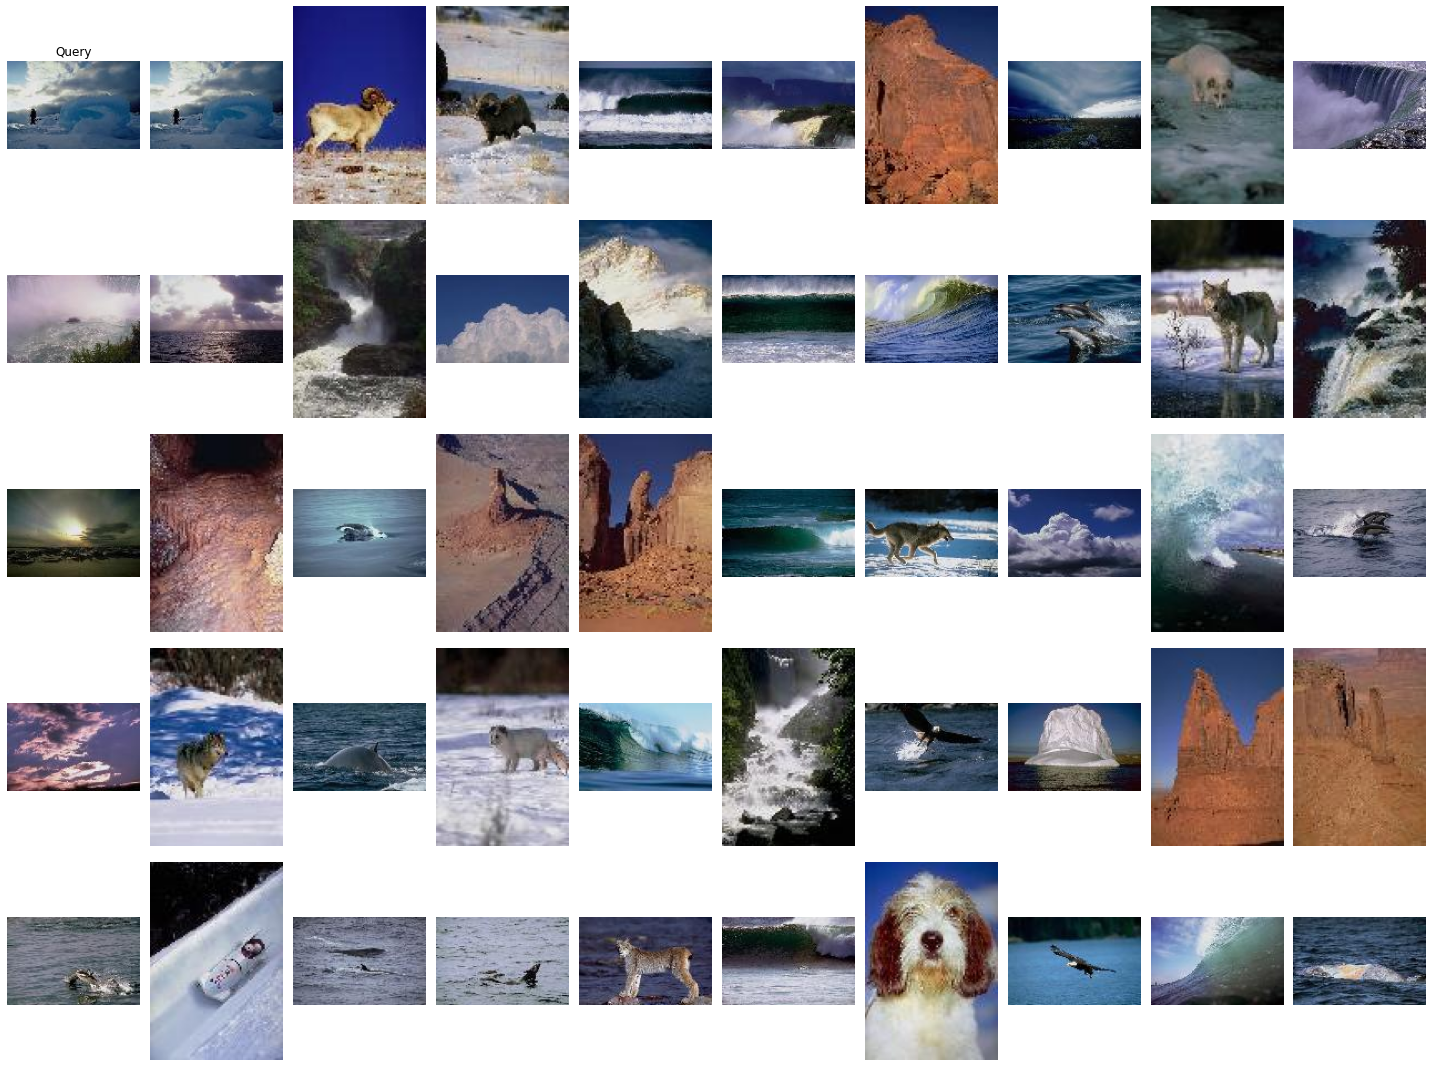

In [99]:
K = 50
indices = closest_idx[:K-1]
nearest_images = [(anc_img_names.iloc[i], distances[i]) for i in indices]

# grid_size = int(math.sqrt(K))
grid_row = 5
grid_col = 10
fig, axes = plt.subplots(grid_row, grid_col, figsize=(20, 15))
k = 0
for i in range(grid_row):
    for j in range(grid_col):
        if i == 0 and j == 0:
            axes[i, j].set_title("Query")
            image = cv2.imread(image_path_query)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(image)
            axes[i, j].axis('off')
            k += 1
        else:
            file_path, distance = nearest_images[k-1]
            # axes[i, j].set_title(distance)
            image = cv2.imread(file_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(image)
            axes[i, j].axis('off')
            k += 1
plt.tight_layout()
plt.show()